# Measurement Correction

* **Last Updated:** Jan 24, 2019
* **Requires:** qiskit-terra 0.7

The idea behind measurement correction is to prepare all 2^n basis states and measure the probability of measuring counts in the other basis states. From these calibrations we can correct the average results of other experiment.

In [144]:
%autoreload 2

In [145]:
# Needed for functions
import numpy as np
import time

# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Measurement correction functions
import sys, os
sys.path.append(os.path.abspath(os.path.join('../qiskit_ignis')))
import measurement_correction as meas_corr

## 3 Qubit Example of the Calibration Matrices

Here we will generate a calibration matrix for 3 qubits in a 5 qubit sample

In [146]:
#generate a noise model for the qubits
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.75, 0.25],[0.1,0.9]])
    noise_model.add_readout_error(read_err,[qi])

In [147]:
#generate the calibration circuits
qr = qiskit.QuantumRegister(5)
meas_calibs, state_labels = meas_corr.measurement_calibration_circuits([qr[2],qr[3],qr[4]])

In [148]:
#run the calibration circuits
backend = Aer.get_backend('qasm_simulator')
qobj = qiskit.compile(meas_calibs, backend=backend, shots=1000)
job = backend.run(qobj, noise_model=noise_model)
cal_results = job.result()

In [149]:
#make a calibration matrix
cal_matrix = meas_corr.generate_calibration_matrix(cal_results,state_labels)
print(cal_matrix)

[[0.457 0.063 0.049 0.004 0.05  0.004 0.008 0.002]
 [0.131 0.52  0.015 0.069 0.015 0.062 0.002 0.008]
 [0.126 0.01  0.521 0.075 0.021 0.006 0.071 0.011]
 [0.049 0.154 0.165 0.584 0.005 0.028 0.02  0.063]
 [0.132 0.022 0.015 0.003 0.503 0.063 0.067 0.006]
 [0.044 0.172 0.007 0.023 0.178 0.595 0.018 0.078]
 [0.05  0.006 0.162 0.025 0.165 0.026 0.631 0.094]
 [0.011 0.053 0.066 0.217 0.063 0.216 0.183 0.738]]


## Correct Measurement Noise on a 3Q GHZ State

In [150]:
#make a 3Q GHZ state
cr = ClassicalRegister(3)
ghz = QuantumCircuit(qr, cr)
ghz.h(qr[2])
ghz.cx(qr[2], qr[3])
ghz.cx(qr[3], qr[4])
ghz.measure(qr[2],cr[0])
ghz.measure(qr[3],cr[1])
ghz.measure(qr[4],cr[2])

qobj = qiskit.compile([ghz], backend=backend, shots=5000)
job = backend.run(qobj, noise_model=noise_model)
results = job.result()

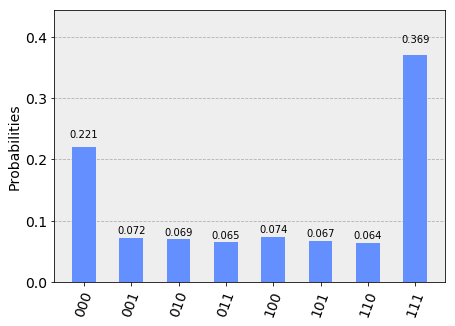

In [151]:
#results without correction
plot_histogram(results.get_counts(0))

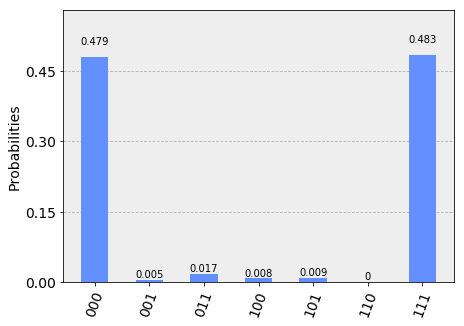

In [154]:
#results with correction
plot_histogram(meas_corr.remove_measurement_errors(results.get_counts(0),state_labels,cal_matrix, method=1))